gradient norm: 1.3272386062890291, minimum ratio: 0.71875
Epoch [0], val_loss: 0.1842
gradient norm: 1.393577042967081, minimum ratio: 0.69921875
Epoch [1], val_loss: 0.1934
gradient norm: 1.459977138787508, minimum ratio: 0.7109375
Epoch [2], val_loss: 0.2031
gradient norm: 1.5264441054314375, minimum ratio: 0.72265625
Epoch [3], val_loss: 0.2132
gradient norm: 1.5929546896368265, minimum ratio: 0.73046875
Epoch [4], val_loss: 0.2238
gradient norm: 1.6595228537917137, minimum ratio: 0.7421875
Epoch [5], val_loss: 0.2348
gradient norm: 1.7261343952268362, minimum ratio: 0.71875
Epoch [6], val_loss: 0.2463
gradient norm: 1.7927875984460115, minimum ratio: 0.73828125
Epoch [7], val_loss: 0.2582
gradient norm: 1.859492002055049, minimum ratio: 0.73046875
Epoch [8], val_loss: 0.2705
gradient norm: 1.926228055730462, minimum ratio: 0.7265625
Epoch [9], val_loss: 0.2833
gradient norm: 1.9930419940501451, minimum ratio: 0.72265625
Epoch [10], val_loss: 0.2965
gradient norm: 2.0598860178142786

[]

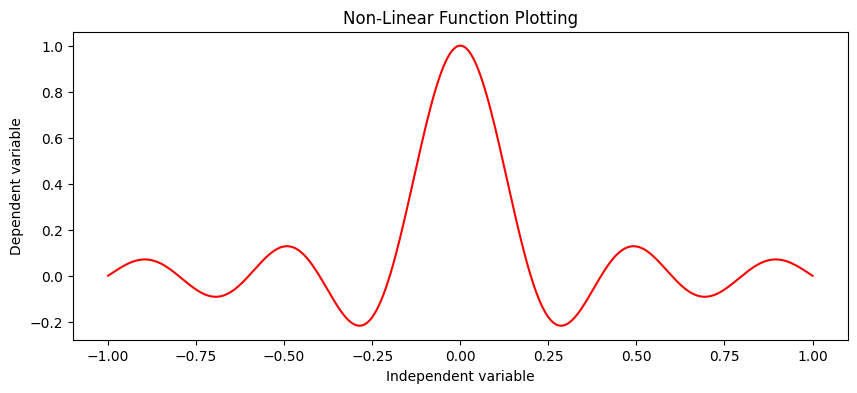

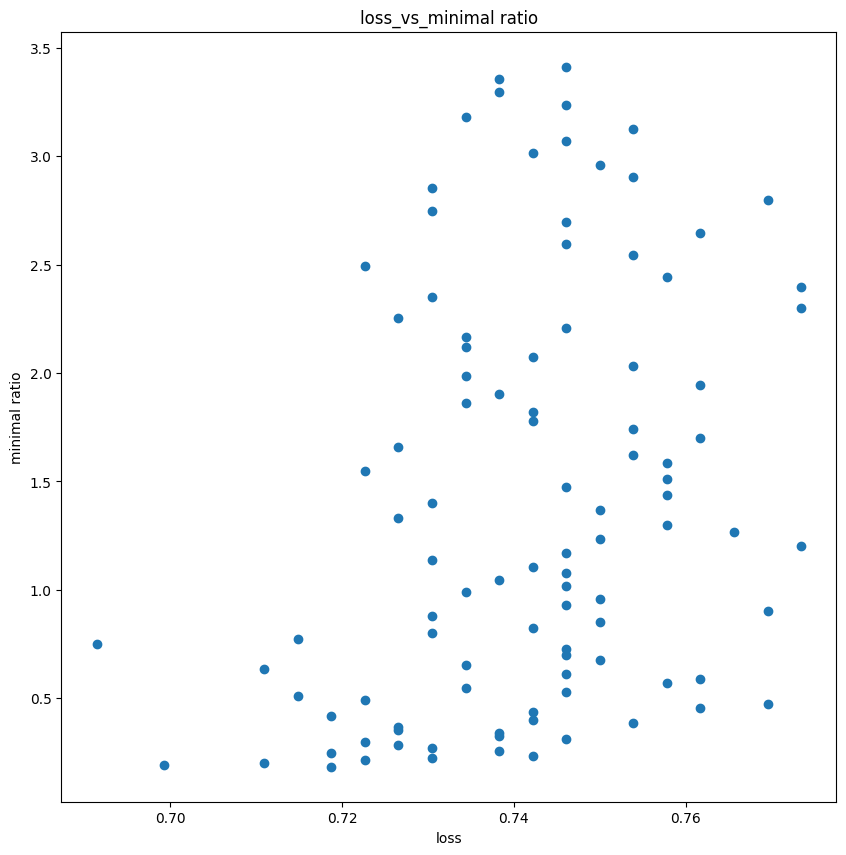

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
torch.manual_seed(42)
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib

from torch.utils.data import DataLoader, TensorDataset


Y_func = lambda x: (torch.sin(5 * np.pi * x)) / (5 * np.pi * x)
num_of_rows = 300
X = torch.unsqueeze(torch.linspace(-1, 1, num_of_rows), dim=1)
Y = Y_func(X)
dataset = TensorDataset(X, Y)
data_loader = DataLoader(dataset, 1, shuffle=True)

plt.figure(figsize=(10, 4))
plt.plot(X.numpy(), Y.numpy(), color="red")
plt.title('Non-Linear Function Plotting')
plt.xlabel('Independent variable')
plt.ylabel('Dependent variable')


class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x

    def training_step(self, batch, loss_fn):
        inputs, targets = batch
        out = self(inputs)  # Generate predictions
        loss = loss_fn(out, targets)  # Calculate loss
        return loss

    def validation_step(self, batch, loss_fn):
        inputs, targets = batch
        out = self(inputs)  # Generate predictions
        loss = loss_fn(out, targets)  # Calculate loss
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        return {'val_loss': epoch_loss.item()}

    def train_step(self, batch, loss_fn):
        inputs, targets = batch
        out = self(inputs)  # Generate predictions
        loss = loss_fn(out, targets)  # Calculate loss
        return {'train_loss': loss.detach()}

    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        return {'train_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads)
    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A)
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)

def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()

    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.linalg.eigvalsh(h, UPLO='L')  # Use torch.linalg.eigvalsh instead of torch.symeig
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio)
    return ratio_mean

def get_norm_minimal_ratio(model, criterion):
    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio

    return result

def evaluate(model, loss_fn, val_loader):
    outputs = [model.validation_step(batch, loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model, loss_fn, train_loader):
    outputs = [model.train_step(batch, loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all = 0.0
    grad = 0

    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()

        grad_all += grad

    grad_norm = grad_all ** 0.5
    return grad_norm

def fit(epochs, lr, model, data_loader, criterion, opt_func):
    history = []
    comparing_epoch_loss = 1000.0
    grad_norm_per_epoch = {}
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()  # clear gradients for next train

        prediction = model(X)
        loss = criterion(prediction, Y)  # must be (1. nn output, 2. target)
        loss.backward()  # backpropagation, compute gradients

        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model, criterion)

        optimizer.step()

        optimizer.zero_grad()
        result = evaluate(model, criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)

        if epoch == 900:
            comparing_epoch_loss = result["val_loss"]

    return history, grad_norm_per_epoch, model

num_of_rows = 300
lr = 0.0004
gamma_lr_scheduler = 0.1
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs = 2500
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
filename = criterion_name + optimizer_name + ".png"
grad_norm_name = "_grad_norm_name1_2.png"


criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs = 100
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
input_size = 1
output_size = 1
model = MathRegressor()

autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)

result_1 = evaluate(model, criterion, data_loader)
result_1

history_1, grad_norm_1, model_1 = fit(num_epochs, lr, model, data_loader, criterion, optimizer)
grad_norm_1

val_losses_1 = [r['val_loss'] for r in history_1]
len(val_losses_1)

minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values()]

plt.figure(figsize=(10, 10))
plt.scatter(minimal_ratio_eps, val_losses_1)
plt.xlabel('loss')
plt.ylabel('minimal ratio')
plt.title('loss_vs_minimal ratio')
plt.plot()

